In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import pickle
from keras import Sequential, Input, layers

import random

seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [2]:

data_dir ='data' # Change to the path to your directory
train_images_dir = os.path.join(data_dir, 'Training')
test_images_dir = os.path.join(data_dir, 'Testing')

# 1. Load saved train, val, test datasets and class names

In [3]:
# Load the arrays from the saved files
X_train = np.load(f'{data_dir}/X_train.npy')
y_train = np.load(f'{data_dir}/y_train.npy')
X_val = np.load(f'{data_dir}/X_val.npy')
y_val = np.load(f'{data_dir}/y_val.npy')

X_test = np.load(f'{data_dir}/X_test.npy')
y_test = np.load(f'{data_dir}/y_test.npy')

print("Training and validation datasets have been loaded successfully.")

with open(f'{data_dir}/class_names_train.pkl', 'rb') as file:
    class_names_train = pickle.load(file)

with open(f'{data_dir}/class_names_test.pkl', 'rb') as file:
    class_names_test = pickle.load(file)

print(f"Loaded class names: {class_names_train} {class_names_test}")
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

Training and validation datasets have been loaded successfully.
Loaded class names: ['glioma', 'meningioma', 'notumor', 'pituitary'] ['glioma', 'meningioma', 'notumor', 'pituitary']
(4608, 30, 30, 1) (1104, 30, 30, 1) (1311, 30, 30, 1)
(4608, 4) (1104, 4) (1311, 4)


# 2. Summarize loss and **accuracy**

In [4]:
# plot diagnostic learning curves
def summarize_loss(history):
    plt.figure(figsize=(6, 4))
    plt.title('Baseline Model Training and Validation Loss')
    plt.plot(range(1,len(history.history['loss']) + 1),history.history['loss'], color='red', label='Train loss')
    plt.plot(range(1,len(history.history['val_loss']) + 1),history.history['val_loss'], color='green', label='Validation loss')
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, which='both', linestyle='-')
    val_loss = history.history['val_loss']
    best_epoch = val_loss.index(min(val_loss)) + 1
    plt.scatter(best_epoch, val_loss[best_epoch - 1], color='blue', s=20, label=f'best epoch= {best_epoch}')
    plt.legend(loc='upper right', fontsize='x-small')
    plt.show()
    return

def summarize_accuracy(history):
    plt.figure(figsize=(6, 4))
    plt.title('Baseline Model Training and Validation Accuracy')
    plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], color='red', label='Train accuracy')
    plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], color='green', label='Validation accuracy')
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True, which='both', linestyle='-')
    val_accuracy = history.history['val_accuracy']
    best_epoch = val_accuracy.index(max(val_accuracy)) + 1
    plt.scatter(best_epoch, val_accuracy[best_epoch - 1], color='blue', s=20, label=f'best epoch= {best_epoch}')
    plt.legend(loc='upper left', fontsize='x-small')
    plt.show()
    return

# 3. Plot ROC **curve**

In [5]:

def plot_roc_curve(model, X, y, class_names):
    """
    Plots the ROC curve for the validation set without the macro-average.

    Parameters:
    - model: Trained model used to predict the validation set.
    - X:  feature data.
    - y: True labels for the dataset set.
    - class_names: List of class names for labeling the ROC curve plot.
    """

    # Get model predictions for the validation set
    y_pred = model.predict(X)
    y_true = np.argmax(y, axis=1)

    # Binarize the output for multi-class ROC curve
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    y_pred_bin = y_pred

    # Compute ROC curve and ROC AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(10, 8))

    for i, class_name in enumerate(class_names):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {} (area = {:.2f})'.format(class_name, roc_auc[i]))

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='best')
    plt.show()

    return roc_auc

# 4. Plot confusion matrix

In [6]:

def plot_confusion_matrix(model, X, y, class_names, normalize=False):
    """
    Generates and plots the confusion matrix.

    Parameters:
    - model: Trained model used to predict the dataset.
    - X: Feature data (validation or test set).
    - y: True labels for the dataset.
    - class_names: List of class names for labeling the confusion matrix.
    - normalize: If True, normalize the confusion matrix by dividing by the sum of rows.
    """
    # Get model predictions
    y_pred = model.predict(X)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Normalize confusion matrix if specified
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)

    # Customize the plot
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.title('Confusion Matrix' + (' (Normalized)' if normalize else ''))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [7]:
def baseline():
    baseline = Sequential()
    baseline.add(Input(shape = (30, 30, 1)))
    baseline.add(layers.Conv2D(32, (3, 3), activation = "relu"))
    baseline.add(layers.MaxPooling2D((2, 2)))
    baseline.add(layers.Conv2D(32, (3, 3), activation = "relu"))
    baseline.add(layers.MaxPooling2D((2, 2)))
    baseline.add(layers.Flatten())
    baseline.add(layers.Dense(32, activation = "relu"))
    baseline.add(layers.Dense(4, activation = "softmax"))
    baseline.compile(optimizer = "adam",
                    loss = "categorical_crossentropy",
                    metrics = ["accuracy"])
    return baseline

Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4378 - loss: 1.1887 - val_accuracy: 0.6721 - val_loss: 0.8587
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7181 - loss: 0.7542 - val_accuracy: 0.7292 - val_loss: 0.7105
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7694 - loss: 0.6324 - val_accuracy: 0.7409 - val_loss: 0.6542
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7905 - loss: 0.5691 - val_accuracy: 0.7527 - val_loss: 0.6271
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8032 - loss: 0.5271 - val_accuracy: 0.7591 - val_loss: 0.6109
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8193 - loss: 0.4926 - val_accuracy: 0.7690 - val_loss: 0.6061
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8308 - loss: 0.4606 - val_accuracy: 0.7672 - val_loss: 0.6051
Epoch 8/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8449 - loss: 0.4323 - val_accuracy: 

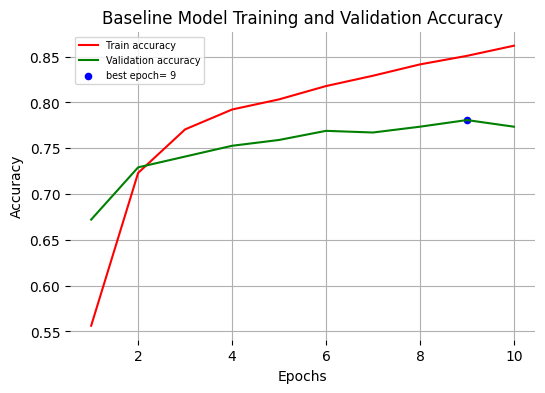

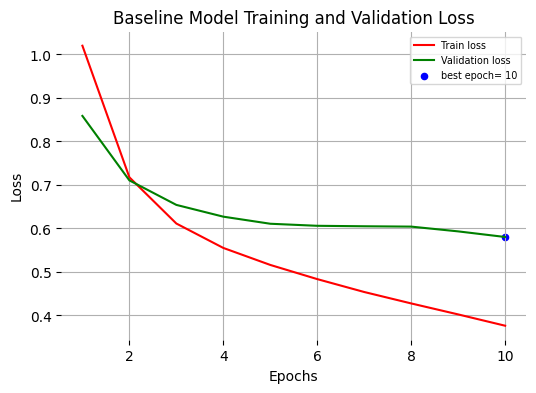

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


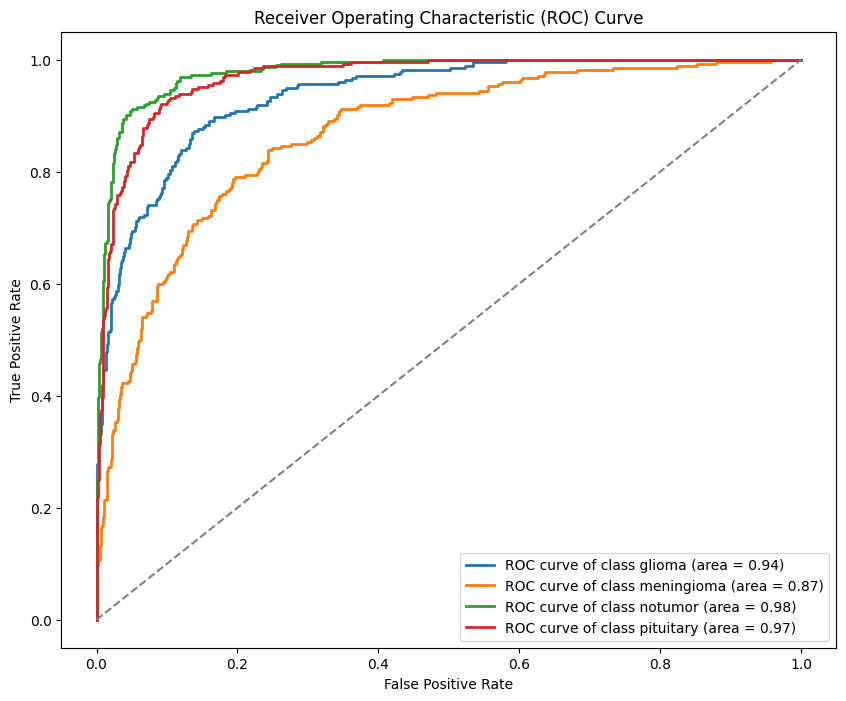

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


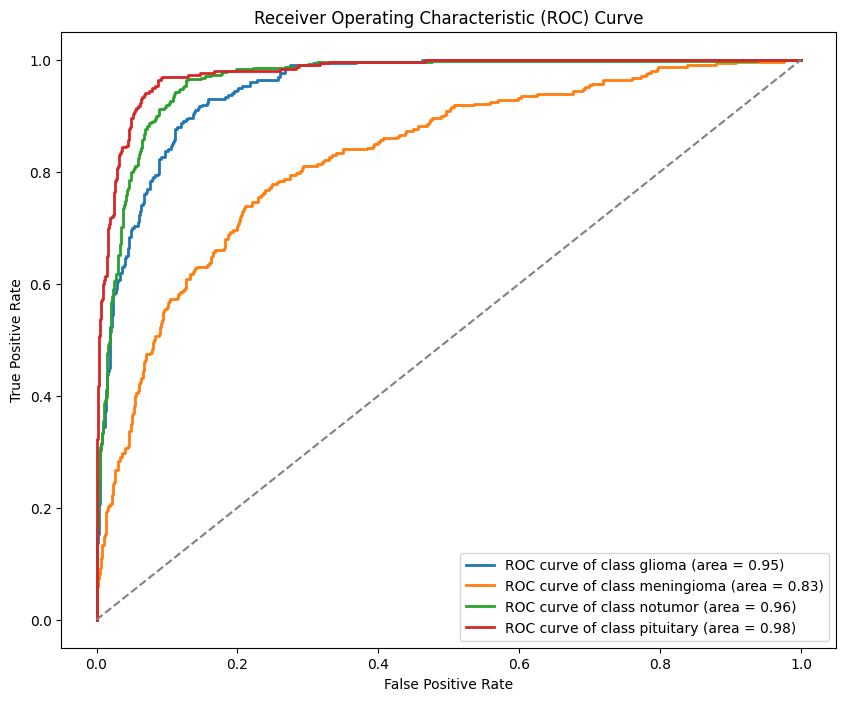

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


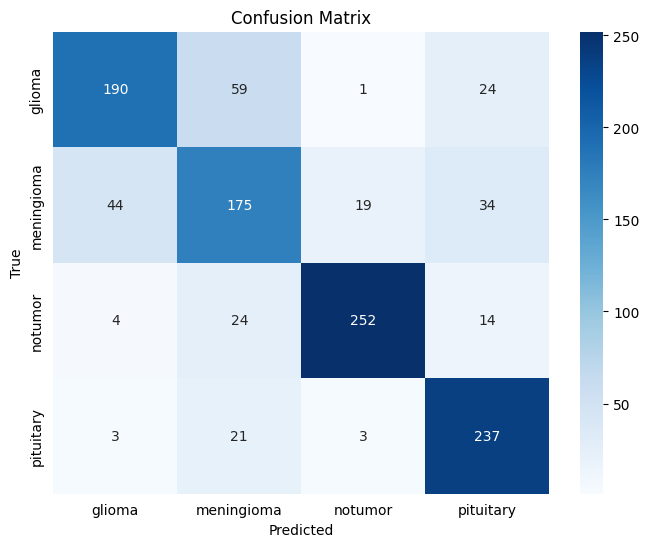

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


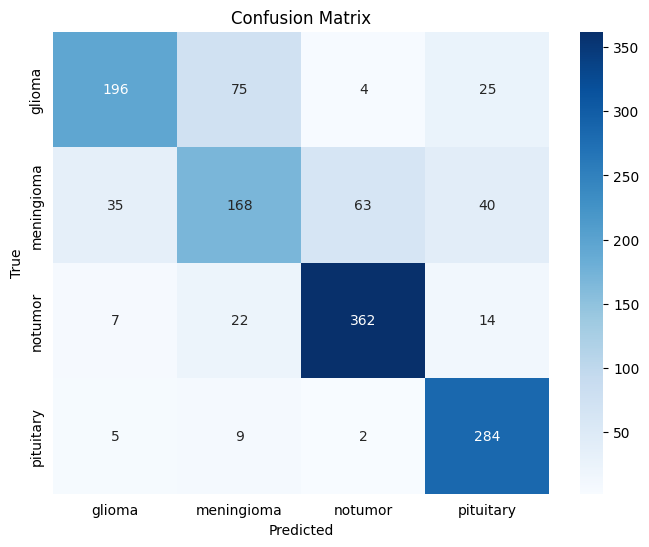

In [8]:
base = baseline()
history = base.fit(X_train, y_train, batch_size =32, epochs = 10, validation_data = (X_val, y_val))

summarize_accuracy(history)
summarize_loss(history)

roc_auc_val = plot_roc_curve(base, X_val, y_val, class_names_train)
roc_auc_test = plot_roc_curve(base, X_test, y_test, class_names_test)

plot_confusion_matrix(base, X_val, y_val, class_names_train, normalize=False)
plot_confusion_matrix(base, X_test, y_test, class_names_test, normalize=False)